In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Install Dependencies

In [2]:
from IPython.display import clear_output
!pip install torch
!pip install torchvision
!pip install captum
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install cleverhans
!pip install cachetools
!pip install pandas
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
clear_output()

In [4]:
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(os.listdir("skin-cancer"))

['HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_28_28_L.csv', 'hmnist_8_8_L.csv', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2']


In [5]:
from matplotlib.image import imread
import seaborn as sns
import random
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid

## Data Preprocessing

In [6]:
data_dir = 'skin-cancer'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
#extracts the image id to match it with the .csv label file
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0] : x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
input_size = 224

In [7]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)

def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)

df_undup = df_original[df_original['duplicates'] == 'unduplicated']
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)

def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']

data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()


/tmp/ipykernel_19/4162347508.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [8]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Model

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

In [12]:
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

## Dataset

In [13]:
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [14]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [15]:
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)
loaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(training_set), 'val':len(validation_set)}

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

## Training

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [19]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.27781], [train acc 0.52187]
[epoch 1], [iter 200 / 1124], [train loss 1.13866], [train acc 0.57828]
[epoch 1], [iter 300 / 1124], [train loss 1.07006], [train acc 0.60625]
[epoch 1], [iter 400 / 1124], [train loss 1.01230], [train acc 0.62398]
[epoch 1], [iter 500 / 1124], [train loss 0.98033], [train acc 0.63656]
[epoch 1], [iter 600 / 1124], [train loss 0.94272], [train acc 0.65010]
[epoch 1], [iter 700 / 1124], [train loss 0.91199], [train acc 0.66013]
[epoch 1], [iter 800 / 1124], [train loss 0.88379], [train acc 0.66977]
[epoch 1], [iter 900 / 1124], [train loss 0.86007], [train acc 0.67833]
[epoch 1], [iter 1000 / 1124], [train loss 0.83920], [train acc 0.68550]
[epoch 1], [iter 1100 / 1124], [train loss 0.82092], [train acc 0.69247]
------------------------------------------------------------
[epoch 1], [val loss 0.45658], [val acc 0.84339]
------------------------------------------------------------
***********************************

## Attacks

In [21]:
!pip install captum
!pip install cleverhans
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import LimeBase
from captum.attr import KernelShap
from captum.attr import Occlusion
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent
)
clear_output()

## Statistical Methods

In [22]:
def compute_mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    
def compute_median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 
def compute_iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    
def compute_coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

def compute_coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25)
        scores.append(score_qt)
    return scores
    

In [ ]:
interested_layers = [14,24,35,45,56,67,70]

def collect_layers(model, interested_layers):
	if model.framework == 'keras':
		outputs = [layer.output for layer in model.layers]
	elif model.framework == 'tensorflow':
		outputs = model.layers

	outputs = [output for i, output in enumerate(outputs) if i in interested_layers]
	print(outputs)
	features = []
	for output in outputs:
		print(output)
		if len(output.get_shape())== 4:
			features.append(
				tf.reduce_mean(output, axis = (1, 2))
			)
		else:
			features.append(output)
	return features

			
def evaluate_features(x, model, features):
	x = np.array(x)
	if len(x.shape) == 3:
		_x = np.expand_dims(x, 0) 
	else:
		_x = x

	batch_size = 500
	num_iters = int(math.ceil(len(_x) * 1.0 / batch_size))

	outs = []
	for i in range(num_iters):
		x_batch = _x[i * batch_size: (i+1) * batch_size]
		out = model.sess.run(features, 
			feed_dict = {model.input_ph: x_batch})

		outs.append(out)

	num_layers = len(outs[0])
	outputs = []
	for l in range(num_layers):
		outputs.append(np.concatenate([outs[s][l] for s in range(len(outs))]))

	# (3073, 64)
	# (3073, 64)
	# (3073, 128)
	# (3073, 128)
	# (3073, 256)
	# (3073, 256)
	# (3073, 10)
	# (3073, 1)
	outputs = np.concatenate(outputs, axis = 1)
	prob = outputs[:,-model.num_classes:]
	label = np.argmax(prob[-1])
	print('outputs', outputs.shape)
	print('prob[:, label]', np.expand_dims(prob[:, label], axis = 1).shape)
	outputs = np.concatenate([outputs, np.expand_dims(prob[:, label], axis = 1)], axis = 1)

	return outputs


def loo_ml_instance(sample, reference, model, features):
	h,w,c = sample.shape
	sample = sample.reshape(-1)
	reference = reference.reshape(-1)

	data = []
	st = time.time()
	positions = np.ones((h*w*c + 1, h*w*c), dtype = np.bool)
	for i in range(h*w*c):
		positions[i, i] = False
	
	data = np.where(positions, sample, reference)

	data = data.reshape((-1, h, w, c))
	features_val = evaluate_features(data, model, features) # (3072+1, 906+1)
	st1 = time.time()

	return features_val


def generate_ml_loo_features(args, data_model, reference, model, x, interested_layers):
	# print(args.attack)
	# x = load_examples(data_model, attack)
	features = collect_layers(model, interested_layers)

	cat = {'original':'ori', 'adv':'adv', 'noisy':'noisy'}
	dt = {'train':'train', 'test':'test'}
	stat_names = ['std', 'variance', 'con', 'kurtosis', 'skewness', 'quantile', 'mad']

	combined_features = {data_type: {} for data_type in ['test', 'train']}
	for data_type in ['test', 'train']:
		print('data_type', data_type)
		for category in ['original', 'adv']:
			print('category', category)
			all_features = []
			for i, sample in enumerate(x[data_type][category]):
				print('Generating ML-LOO for {}th sample...'.format(i))
				features_val = loo_ml_instance(sample, reference, model, features)
				
				# (3073, 907)
				print('features_val.shape', features_val.shape)
				features_val = np.transpose(features_val)[:,:-1]
				print('features_val.shape', features_val.shape)
				# (906, 3073)
				single_feature = []
				for stat_name in stat_names:
					print('stat_name', stat_name)
					single_feature.append(calculate(features_val, stat_name))

				single_feature = np.array(single_feature)
				print('single_feature', single_feature.shape)
				# (k, 906)
				all_features.append(single_feature)
			print('all_features', np.array(all_features).shape)
			combined_features[data_type][category] = np.array(all_features)

			np.save('{}/data/{}_{}_{}_{}_{}.npy'.format(
				data_model,
				args.data_sample,
				dt[data_type],
				cat[category],
				args.attack, 
				args.det), 
				combined_features[data_type][category])

	return combined_features


def compute_stat_single_layer(output):
	# l2dist = pdist(output)
	# l1dist = pdist(output, 'minkowski', p = 1)
	# sl2dist = pdist(X, 'seuclidean')
	variance = np.sum(np.var(output, axis = 0))
	# on = np.sum(np.linalg.norm(output, ord = 1, axis = 0))
	con = np.sum(np.linalg.norm(output - np.mean(output, axis = 0), ord = 1, axis = 0))

	return variance, con


def load_features(data_model, attacks):
	def softmax(x, axis):
		"""Compute softmax values for each sets of scores in x."""
		e_x = np.exp(x - np.max(x, axis = axis, keepdims = True))
		return e_x / e_x.sum(axis=axis, keepdims = True) # only difference      

	cat = {'original':'', 'adv':'_adv', 'noisy':'_noisy'}
	dt = {'train':'_train', 'test':''}
	features = {attack: {'train': {}, 'test': {}} for attack in attacks}

	normalizer = {}
	for attack in attacks:
		for data_type in ['train', 'test']:
			for category in ['original', 'adv']:
				print('Loading data...')
				feature = np.load('{}/data/{}{}{}_{}_{}.npy'.format(data_model,'x_val200',  
					dt[data_type], 
					cat[category], 
					attack, 
					'ml_loo')) # [n, 3073, ...]
				n = len(feature)
				print('Processing...')
				nums = [0,64,64,128,128,256,256,10]
				splits = np.cumsum(nums) # [0,64,128,...]
				processed = []
				for j, s in enumerate(splits):
					if j < len(splits) - 1:
						separated = feature[:, :-1, s:splits[j+1]]

						if j == len(splits) - 2:
							separated = softmax(separated, axis = -1)
							
						dist = np.var(separated, axis = 1) # [n, ...]
						if data_type == 'train' and category == 'original' and attack == 'linfpgd':
							avg_dist = np.mean(dist, axis = 0)
							normalizer[j] = avg_dist

						# dist /= normalizer[j]
						dist = np.sqrt(dist)

						# max_dist = np.max(dist, axis = -1)
						print(np.mean(dist))
						processed.append(dist.T)

				processed = np.concatenate(processed, axis = 0).T
				# processed = np.concatenate(processed, axis = )


				print(processed.shape)

				features[attack][data_type][category] = processed

	return features

## Integrated Gradient

In [32]:
gc.collect()
torch.cuda.empty_cache()

dataiter = iter(val_loader)

igmedianAbs_ben = []
igmeanAbs_ben = []
igiqr_ben = []
igcoef_var_ben=[]
igcoef_iqr_ben = []

igmedianAbs_bena = []
igmeanAbs_bena = []
igiqr_bena = []
igcoef_var_bena=[]
igcoef_iqr_bena = []

for i in range(30):
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    for ind in range(32):
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        ig = IntegratedGradients(model)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        # attr_ig = ig.attribute(input1, target=labels[ind])
        # attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        igmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        igmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        igiqr_ben += compute_iqr(a_batch_benign)
        igcoef_var_ben += compute_coef_var(a_batch_benign)
        igcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        # torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.3, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        # index = (y_pred_pgd != labels)
        # pgd_images = images_pgd[index]
        # y_pred_pgd = y_pred_pgd[index]
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        igmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        igiqr_bena += compute_iqr(a_batch_attack)
        igcoef_var_bena += compute_coef_var(a_batch_attack)
        igcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
        # images_pgd = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
        # attr_ig = ig.attribute(inputs=images_pgd, target=y_pred_pgd)
        # attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        # _ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
        #                   show_colorbar=True, title="Overlayed Integrated Gradients")
    gc.collect()
    torch.cuda.empty_cache()


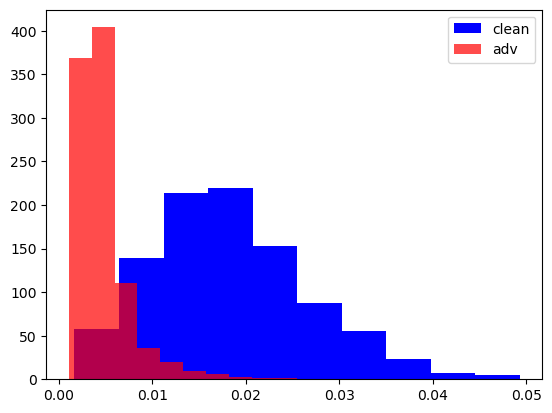

In [33]:
plt.hist(igiqr_ben, label='clean', color='blue')
plt.hist(igiqr_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()

## Saliency

In [ ]:
gc.collect()
torch.cuda.empty_cache()

ind = 2
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)


salmedianAbs_ben = []
salmeanAbs_ben = []
saliqr_ben = []
salcoef_var_ben=[]
salcoef_iqr_ben = []

salmedianAbs_bena = []
salmeanAbs_bena = []
saliqr_bena = []
salcoef_var_bena=[]
salcoef_iqr_bena = []

for i in range(30):
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    for ind in range(32):
        gc.collect()
        torch.cuda.empty_cache()
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        ig = Saliency(model)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        salmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        salmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        saliqr_ben += compute_iqr(a_batch_benign)
        salcoef_var_ben += compute_coef_var(a_batch_benign)
        salcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        # torch.cuda.empty_cache()
        images_pgd = fast_gradient_method(model, input1, 0.1, np.inf)
        _, y_pred_pgd = model(input1).max(1)
        # index = (y_pred_pgd != labels)
        # pgd_images = images_pgd[index]
        # y_pred_pgd = y_pred_pgd[index]
        a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
        salmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
        salmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
        saliqr_bena += compute_iqr(a_batch_attack)
        salcoef_var_bena += compute_coef_var(a_batch_attack)
        salcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
        gc.collect()
        torch.cuda.empty_cache()


/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [ ]:
plt.hist(saliqr_ben, label='clean', color='blue')
plt.hist(saliqr_bena, label='adv', alpha=0.7, color='red')
plt.legend()
plt.show()